
# Install fastai dependencies

In [1]:
pip install fastai

Note: you may need to restart the kernel to use updated packages.


In [2]:
# Import required libraries from fastai and other necessary modules
from fastai.vision.all import *
# from google.colab import drive
from pathlib import Path
import os

# Download Custom Classification Data From Roboflow

['0', '1']


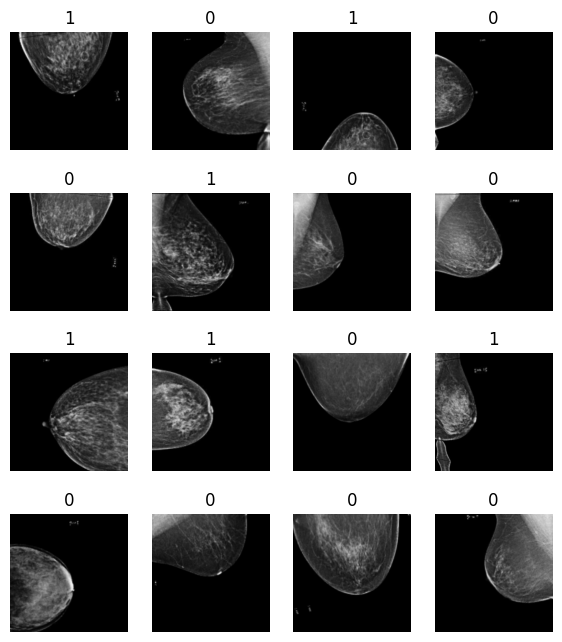

In [3]:
# Define the path to your dataset
dataset_path = './dataset'

# Load the dataset
# Ensure your dataset has '0' and '1' directories representing classes
data = ImageDataLoaders.from_folder(
    dataset_path,
    valid_pct=0.2,
    item_tfms=Resize(224),
    batch_tfms=[*aug_transforms(), Normalize.from_stats(*imagenet_stats)]
)

# Check data classes
print(data.vocab)

# Visualize a batch of the dataset
data.show_batch(max_n=16, figsize=(7, 8))

# Set up fastai Resnet model

In [4]:
# Create and train the model
learn = vision_learner(data, resnet50, metrics=error_rate)

# Print network layers
print(learn.model)

Sequential(
  (0): Sequential(
    (0): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
    (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
    (3): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
    (4): Sequential(
      (0): Bottleneck(
        (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu): ReLU(inplace=True)
        (downsample): Sequential(
          (0): Conv2d(64, 256

# Train Custom Resnet Image Classifier

In [5]:

import torch
import gc

# Callbacks for early stopping and saving the best model
early_stop = EarlyStoppingCallback(monitor='error_rate', patience=20)
save_best_model = SaveModelCallback(monitor='error_rate', fname='resnet50')


torch.cuda.empty_cache()
gc.collect()
# def clear_gpu_memory():
#     torch.cuda.empty_cache()
#     gc.collect()
#     del variables

# Use CUDA if available, otherwise use CPU
if torch.cuda.is_available():
    # clear_gpu_memory()
    learn.dls.cuda()
    print("Using GPU (CUDA)")
    learn.fit_one_cycle(10, cbs=[early_stop, save_best_model])
else:
    learn.dls.cpu()
    print("Using CPU")

# Train with frozen layers

Using GPU (CUDA)


epoch,train_loss,valid_loss,error_rate,time
0,1.194765,0.979491,0.473118,00:07
1,1.172769,0.949695,0.465950,00:06
2,1.112600,1.131019,0.494624,00:06
3,1.061707,0.949584,0.419355,00:06
4,1.004297,0.782000,0.379928,00:06
5,0.932439,0.733127,0.354839,00:06
6,0.873317,0.751373,0.365591,00:06
7,0.819003,0.778886,0.408602,00:06
8,0.772469,0.768293,0.405018,00:06
9,0.739905,0.753372,0.415771,00:06


Better model found at epoch 0 with error_rate value: 0.47311827540397644.
Better model found at epoch 1 with error_rate value: 0.4659498333930969.
Better model found at epoch 3 with error_rate value: 0.4193548262119293.
Better model found at epoch 4 with error_rate value: 0.379928320646286.
Better model found at epoch 5 with error_rate value: 0.35483869910240173.


In [8]:
# Load best model from frozen training
learn.load('resnet50')
SaveModelCallback(monitor='error_rate', fname='resnet50',with_opt=True)
# Unfreeze the model
learn.unfreeze()

# Function to find the appropriate learning rate
def find_appropriate_lr(model:Learner, lr_diff:int = 15, loss_threshold:float = .05, adjust_value:float = 1, plot:bool = False) -> float:
    # Run the Learning Rate Finder
    model.lr_find()

    # Get loss values and their corresponding gradients, and get lr values
    losses = np.array(model.recorder.losses)
    min_loss_index = np.argmin(losses)

    # Get learning rates
    lrs = model.recorder.lrs

    # Return the learning rate that produces the minimum loss divided by 10
    return lrs[min_loss_index] / 10




epoch,train_loss,valid_loss,error_rate,time
0,0.865718,0.744848,0.369176,00:08
1,0.804279,0.755380,0.387097,00:08
2,0.798486,0.753421,0.387097,00:08
3,0.785054,0.761830,0.376344,00:08
4,0.770725,0.753216,0.372760,00:08
5,0.774533,0.765806,0.383513,00:08
6,0.783938,0.749963,0.362007,00:08
7,0.775483,0.757840,0.372760,00:08
8,0.788847,0.765684,0.383513,00:08
9,0.798889,0.752249,0.379928,00:08


Better model found at epoch 0 with error_rate value: 0.36917561292648315.
Better model found at epoch 6 with error_rate value: 0.36200717091560364.
Better model found at epoch 14 with error_rate value: 0.3476702570915222.
No improvement since epoch 14: early stopping


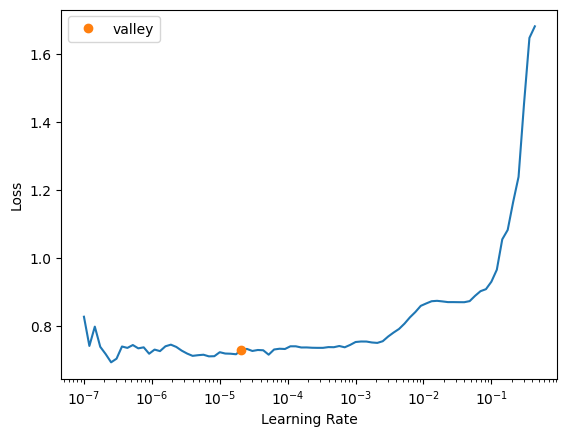

In [9]:
import torch

# Find the optimal learning rate
optimal_lr = find_appropriate_lr(learn)

# Fine-tune the model with the optimal learning rate
learn.unfreeze()
learn.fit_one_cycle(100, lr_max=slice(optimal_lr/10, optimal_lr), cbs=[early_stop, save_best_model])

# Load the best model after fine-tuning
learn.load('resnet50')

# Assuming your model is named 'model'
# Assuming your optimizer is named 'optimizer'
# Assuming you want to save the model to a file named 'model.pth'

# Save the model and optimizer state
torch.save({
    'optimizer_state_dict':learn.model.state_dict()
}, 'dataset/models/resnet50.pth')

# Evaluate Classifier Performance

              precision    recall  f1-score   support

           0       0.64      0.71      0.67       139
           1       0.67      0.60      0.63       140

    accuracy                           0.65       279
   macro avg       0.65      0.65      0.65       279
weighted avg       0.65      0.65      0.65       279



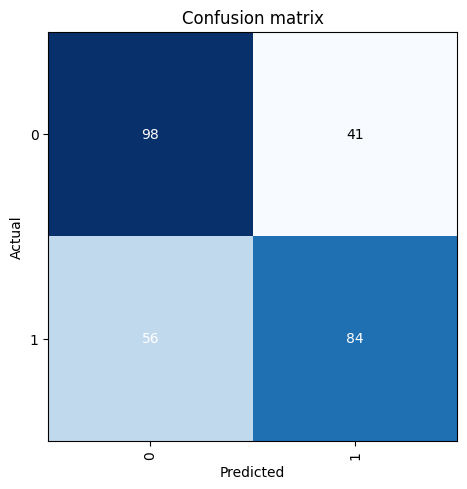

In [10]:
# Evaluate the classifier performance
interp = ClassificationInterpretation.from_learner(learn)
interp.plot_confusion_matrix()

# print performance matrix
interp.print_classification_report()

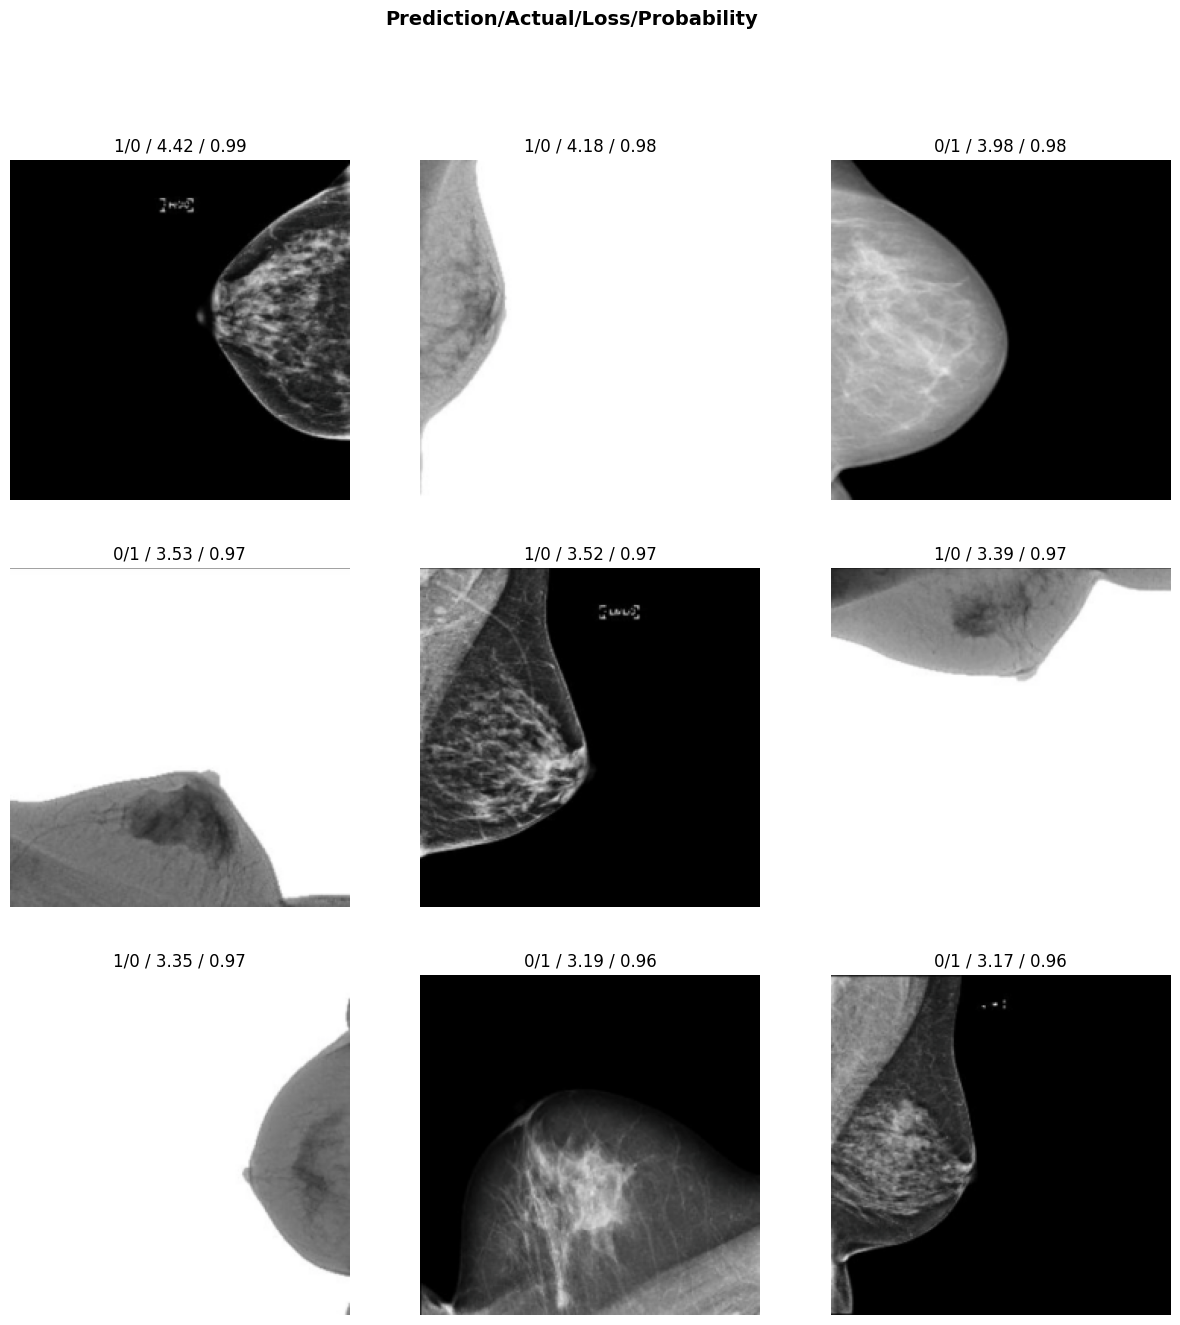

In [11]:
interp.plot_top_losses(9, figsize=(15, 15))

In [ ]:
import gc
import os

# Perform garbage collection
gc.collect()

# Shutdown the kernel
os._exit(00)

: 

In [ ]:
from fastai.vision.all import PILImage

# Run inference on test images
import glob
from IPython.display import Image, display

image_paths = glob.glob('./dataset/0/*.jpg')
print(image_paths)

sumC = 0
total = 0
accuracy = 0

for image_path in image_paths:
    img = PILImage.create(image_path)
    prediction = learn.predict(img)
    if prediction[0] == '1':
        sumC += 1

total = len(image_paths)
accuracy = sumC/total * 100
print("Total: ", total)
print("Correct: ", sumC)
print("Accuracy: ", accuracy)

